<a href="https://colab.research.google.com/github/Evans-tats/machine-learning/blob/main/Multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

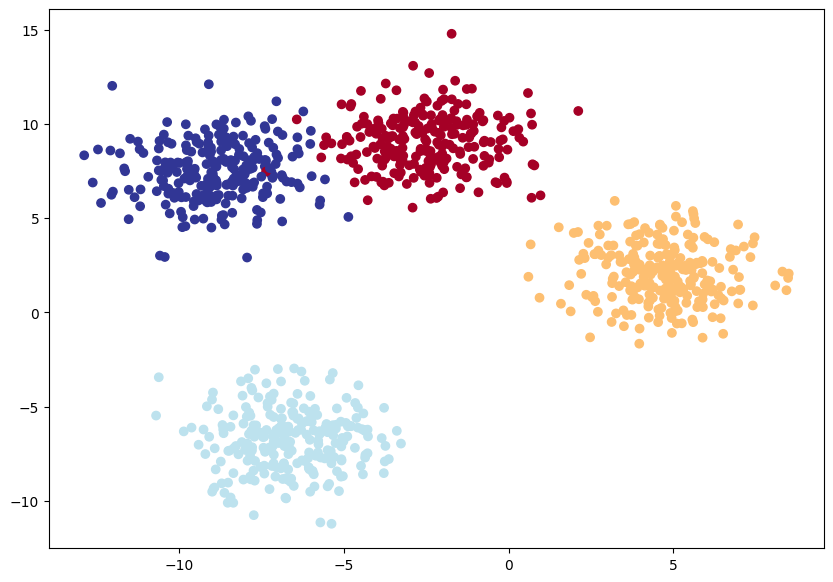

In [169]:
#import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#set the hyperparameters for data creation
NUM_CLASSSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#1. Create multi-class data
X_blob, Y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSSES,
                            cluster_std = 1.5,
                            random_state=RANDOM_SEED)

#2. Turn data into tensors
x_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(Y_blob).type(torch.LongTensor)

#3. Split into train and test
x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

#4. plot the data(visualize visualize visualize)
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);
x_blob_train.shape, y_blob_train.shape, x_blob_test.shape, y_blob_test.shape

In [170]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [171]:
#BUilding multi-class classification model
class BlobModel(torch.nn.Module):

  def __init__(self,input_features, output_features,hidden_units=8):
    """initializes multi class classification model."""
    super().__init__()
    self.Linear_layer_stack = torch.nn.Sequential(
        torch.nn.Linear(in_features=input_features,out_features=hidden_units),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_units, out_features=hidden_units),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.Linear_layer_stack(x)

model= BlobModel (input_features=2,
                  output_features=4,
                  hidden_units=16).to(device)
model

BlobModel(
  (Linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [172]:
# creating loss function for multi calss classification
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [173]:
y_logits = model(x_blob_train.to(device))
y_logits[:10]

tensor([[-0.4566, -0.0930,  0.5090, -0.1771],
        [-0.7904, -0.8356,  0.1357,  1.5065],
        [ 0.1550,  0.0585,  0.2364, -0.0962],
        [ 0.2080, -0.0040,  0.2235,  0.0737],
        [-0.6453, -0.7600,  0.1775,  1.2237],
        [-0.4424, -0.5968,  0.0731,  0.8183],
        [-0.9173, -0.9416,  0.1653,  1.7541],
        [-0.3514, -0.1081,  0.4529, -0.1827],
        [-0.6505, -0.7666,  0.2331,  1.5015],
        [-0.7711, -0.8432,  0.1708,  1.4698]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [174]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [175]:
#convert our model logits output to predictions
y_pred_prob = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_prob)

tensor([[-0.4566, -0.0930,  0.5090, -0.1771],
        [-0.7904, -0.8356,  0.1357,  1.5065],
        [ 0.1550,  0.0585,  0.2364, -0.0962],
        [ 0.2080, -0.0040,  0.2235,  0.0737],
        [-0.6453, -0.7600,  0.1775,  1.2237]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1566, 0.2252, 0.4112, 0.2070],
        [0.0693, 0.0663, 0.1750, 0.6894],
        [0.2652, 0.2408, 0.2877, 0.2063],
        ...,
        [0.0755, 0.0715, 0.1804, 0.6726],
        [0.2729, 0.2313, 0.2872, 0.2085],
        [0.0752, 0.0682, 0.1779, 0.6787]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [176]:
#convert our model prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_prob, dim=1)
#y_preds

CREATING A TRAINING LOOP AND TESTING LOOP FOR A MULTICLASS PyTORCH model


In [177]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

x_blob_train, y_blob_train =x_blob_train.to(device), y_blob_train.to(device)
x_blob_test, y_blob_test = x_blob_test.to(device), y_blob_test.to(device)

#loop through data
for epoch in range(epochs):
  ###training
  model.train()

  y_logits = model(x_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ###Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(x_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss =loss_fn(test_logits, y_blob_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:4f},test loss {test_loss:4f}")


Epoch: 0 | Loss: 1.434949,test loss 1.068203
Epoch: 10 | Loss: 0.387983,test loss 0.376464
Epoch: 20 | Loss: 0.152714,test loss 0.140219
Epoch: 30 | Loss: 0.072872,test loss 0.066483
Epoch: 40 | Loss: 0.055224,test loss 0.048423
Epoch: 50 | Loss: 0.046521,test loss 0.039391
Epoch: 60 | Loss: 0.041411,test loss 0.033931
Epoch: 70 | Loss: 0.038083,test loss 0.030284
Epoch: 80 | Loss: 0.035764,test loss 0.027683
Epoch: 90 | Loss: 0.034065,test loss 0.025734
Epoch: 100 | Loss: 0.032771,test loss 0.024218
Epoch: 110 | Loss: 0.031756,test loss 0.023009
Epoch: 120 | Loss: 0.030939,test loss 0.022011
Epoch: 130 | Loss: 0.030275,test loss 0.021184
Epoch: 140 | Loss: 0.029724,test loss 0.020482
Epoch: 150 | Loss: 0.029259,test loss 0.019880
Epoch: 160 | Loss: 0.028863,test loss 0.019356
Epoch: 170 | Loss: 0.028521,test loss 0.018896
Epoch: 180 | Loss: 0.028223,test loss 0.018490
Epoch: 190 | Loss: 0.027962,test loss 0.018130
Epoch: 200 | Loss: 0.027731,test loss 0.017806
Epoch: 210 | Loss: 0.027

In [178]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


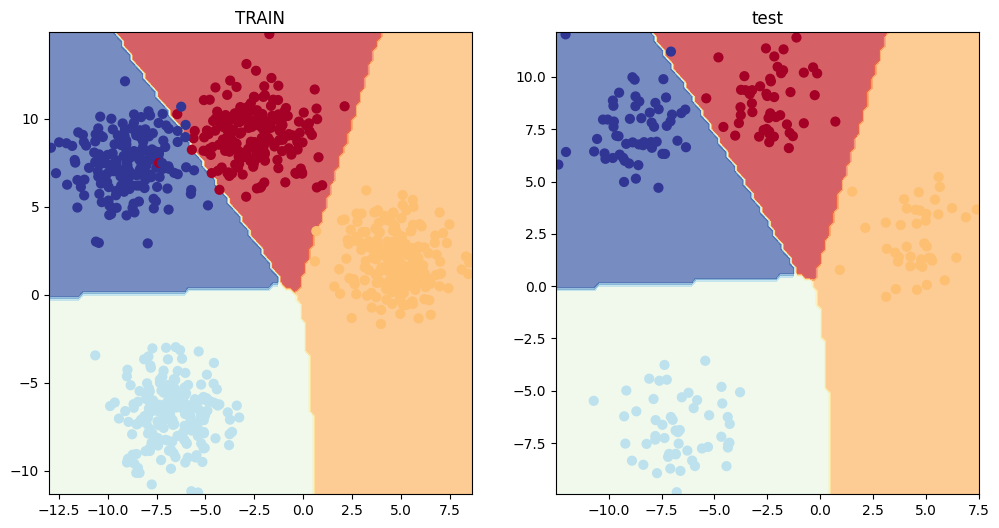

In [179]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("TRAIN")
plot_decision_boundary(model, x_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model,x_blob_test,y_blob_test)